# Case study for Oetelshofen Surface Mine - Segmentation

This notebook is part of a series of notebooks for a case study of the Oetelshofen Surface Mine. In this notebook, we try to segment the Oetelshofen mine from a satellite image using the Segment Anything Model (SAM). 

## Install dependencies

In [1]:
from sentinelhub import SHConfig

config = SHConfig("sentinel-hub-dida-testing")

if not config.sh_client_id or not config.sh_client_secret:
    print("Warning! To use Process API, please provide the credentials (OAuth client ID and client secret).")

In [2]:
import leafmap
from samgeo import SamGeo
from samgeo.text_sam import LangSAM
from ipyleaflet.leaflet import DrawControl
import rasterio

import datetime
import os

import matplotlib.pyplot as plt
import matplotlib.patches as patches
import numpy as np

from sentinelhub import (
    CRS,
    BBox,
    DataCollection,
    MimeType,
    MosaickingOrder,
    SentinelHubRequest,
    bbox_to_dimensions,
)

from amoki.config import DATA_DIR
from amoki.utilities.sentinelhub_utils import plot_image, get_volume_from_dem_array

2024-07-24 10:29:15.176 | INFO     | amoki.config:<module>:7 - PROJ_ROOT path is: /home/ldap_users/iaroslavanovoselova/amoki


## Download image from Sentinel Hub

We download imagery of the Oetelshofen surface mine with the least cloud coverage.

In [3]:
oetelshofen_coords_wgs84 = (7.0267, 51.2328, 7.0526, 51.2486)

In [4]:
resolution = 10
bbox = BBox(bbox=oetelshofen_coords_wgs84, crs=CRS.WGS84)
size = bbox_to_dimensions(bbox, resolution=resolution)

print(f"Image shape at {resolution} m resolution: {size} pixels")

Image shape at 10 m resolution: (185, 171) pixels


In [80]:
evalscript_true_color = """
    //VERSION=3

    function setup() {
        return {
            input: [{
                bands: ["B02", "B03", "B04"]
            }],
            output: {
                bands: 3
            }
        };
    }

    function evaluatePixel(sample) {
        return [sample.B04, sample.B03, sample.B02];
    }
"""

request_true_color = SentinelHubRequest(
    data_folder=DATA_DIR / "case_studies" / "oetelshofen" / "segmentation",
    evalscript=evalscript_true_color,
    input_data=[
        SentinelHubRequest.input_data(
            data_collection=DataCollection.SENTINEL2_L1C,
            time_interval=("2015-07-30", "2015-12-30"),
            mosaicking_order=MosaickingOrder.LEAST_CC,
        )
    ],
    responses=[SentinelHubRequest.output_response("default", MimeType.TIFF)],
    bbox=bbox,
    size=size,
    config=config,
)

In [81]:
img = request_true_color.get_data(save_data=True)

In [ ]:
# Get the last added image
for folder, _, filenames in os.walk(request_true_color.data_folder):
    for filename in filenames:
        if filename.endswith('.tiff'):
            img_path = os.path.join(folder, filename)
            img_folder = folder
            print(os.path.join(folder, filename))

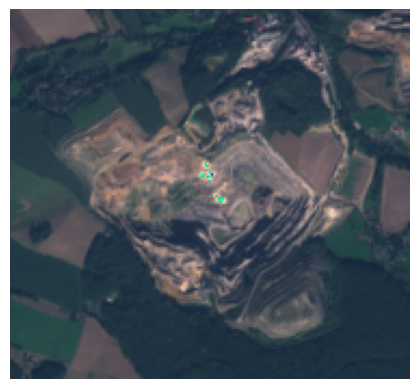

In [105]:
with rasterio.open(img_path) as src:
    img = src.read([1, 2, 3])
    img = img.transpose((1, 2, 0))

plt.imshow(img * 3)
plt.axis('off')
plt.show()

## Generating object masks with text prompts

### Initialize LangSAM class

The initialization of the LangSAM class might take a few minutes. The initialization downloads the model weights and sets up the model for inference.

In [109]:
sam = LangSAM()

final text_encoder_type: bert-base-uncased


### Specify text prompts

In [110]:
text_prompt = "pit"

### Segment the image

Part of the model prediction includes setting appropriate thresholds for object detection and text association with the detected objects. These threshold values range from 0 to 1 and are set while calling the predict method of the LangSAM class.

`box_threshold`: This value is used for object detection in the image. A higher value makes the model more selective, identifying only the most confident object instances, leading to fewer overall detections. A lower value, conversely, makes the model more tolerant, leading to increased detections, including potentially less confident ones.

`text_threshold`: This value is used to associate the detected objects with the provided text prompt. A higher value requires a stronger association between the object and the text prompt, leading to more precise but potentially fewer associations. A lower value allows for looser associations, which could increase the number of associations but also introduce less precise matches.

Remember to test different threshold values on your specific data. The optimal threshold can vary depending on the quality and nature of your images, as well as the specificity of your text prompts. Make sure to choose a balance that suits your requirements, whether that's precision or recall.

In [111]:
masks, boxes, _, logits = sam.predict(img_path, text_prompt, box_threshold=0.24, text_threshold=0.24, return_results=True)

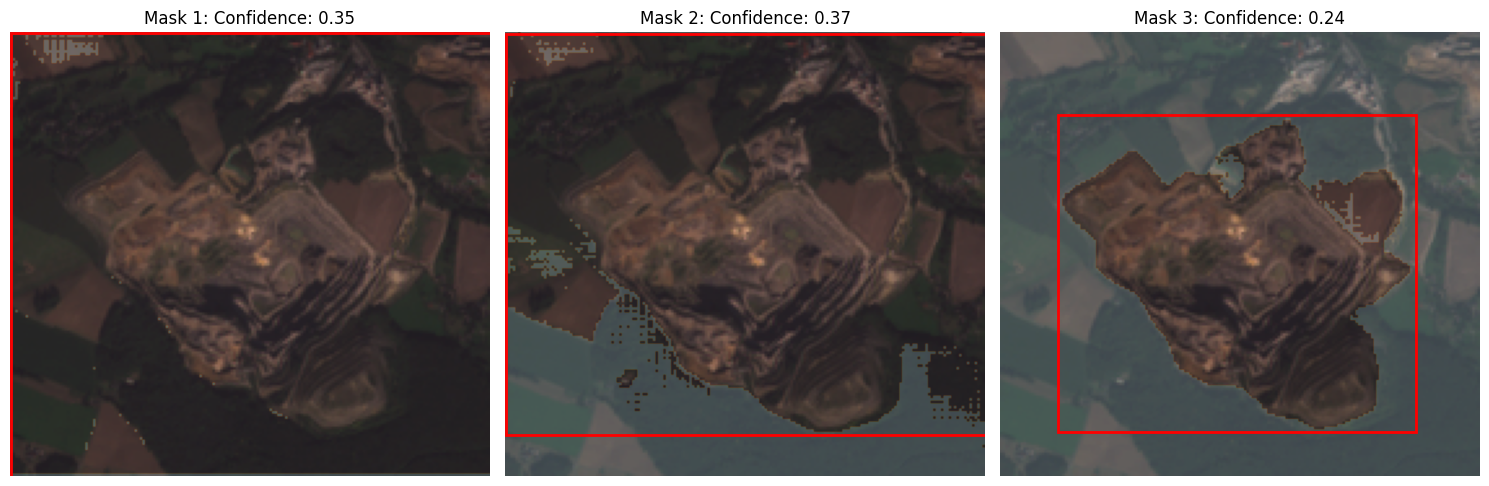

In [112]:
# Plot predicted masks
num_masks = len(masks)

fig, axes = plt.subplots(1, num_masks, figsize=(15, 15))

def plot_image_with_mask_and_box(ax, image, mask, box, title):
    ax.imshow(image*2)
    ax.imshow(mask, alpha=0.2, cmap="YlOrBr")  #

    x, y, width, height = box[0], box[1], box[2] - box[0], box[3] - box[1]
    rect = patches.Rectangle((x, y), width, height, linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)

    ax.set_title(title)
    ax.axis('off')

for i, (mask, box, logit) in enumerate(zip(masks, boxes, logits)):
    plot_image_with_mask_and_box(axes[i], img, mask, box, f"Mask {i+1}: Confidence: {logit:.2f}")

plt.tight_layout()
plt.show()

## Generating object masks from input prompts

### Initialize SAM class

Specify the file path to the model checkpoint. If it is not specified, the model will to downloaded to the working directory.

Set `automatic=False` to disable the `SamAutomaticMaskGenerator` and enable the `SamPredictor`.

In [118]:
sam = SamGeo(
    model_type="vit_h",
    automatic=False,
    sam_kwargs=None,
)

Specify the image to segment. 

In [119]:
sam.set_image(img_path)

### Image segmentation with input points

A single point can be used to segment an object. The point can be specified as a tuple of (x, y), such as (col, row) or (lon, lat). The points can also be specified as a file path to a vector dataset. For non (col, row) input points, specify the `point_crs` parameter, which will automatically transform the points to the image column and row coordinates.

We have selected a point `(7.038589, 51.240775)` that lies in the area of the mine and used it as an input for the segmentation model.

In [120]:
point_coords = [(7.038589, 51.240775)]

In [121]:
masks, scores, _  = sam.predict(point_coords, point_labels=1, point_crs="EPSG:4326",  output=os.path.join(img_folder,"mask.tif"), multimask_output=False, return_results=True)

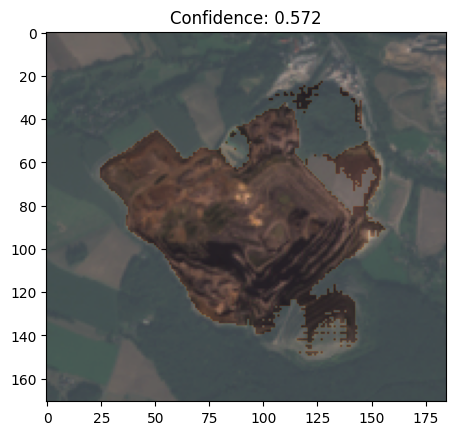

In [122]:
# Plot predicted mask

plt.imshow(img*2)
plt.imshow(masks[0], alpha=0.2, cmap="YlOrBr")
plt.title(f"Confidence: {scores[0]:.3f}")
plt.show()


We can also show the results on an interactive map.  
Note: the satellite imagery that is shown on the map is not the one that we used for segmentation. 

In [21]:
with rasterio.open(img_path) as dataset:
    bounds = dataset.bounds
    center_x = (bounds.left + bounds.right) / 2
    center_y = (bounds.top + bounds.bottom) / 2

    print(f"Center coordinates of the saved satellite image: ({center_x}, {center_y})")

Center coordinates of the saved satellite image: (7.03965, 51.240700000000004)


Convert the result to a vector format.  

In [23]:
sam.raster_to_vector(os.path.join(img_folder,"mask.tif"), os.path.join(img_folder,"mask.shp"))

In [25]:
m = leafmap.Map(center=[center_y, center_x], zoom=15, height="800px")
m.add_basemap("SATELLITE")

m.add_raster(os.path.join(img_folder,"mask.tif"), layer_name="Mask1", palette="YlOrBr", opacity=0.5, nodata=0)
style = {
    "color": "#3388ff",
    "weight": 2,
    "fillColor": "#7c4185",
    "fillOpacity": 0.5,
}
m.add_vector(os.path.join(img_folder,"mask.shp"), layer_name="Vector1", style=style)
m

Map(center=[51.240700000000004, 7.03965], controls=(ZoomControl(options=['position', 'zoom_in_text', 'zoom_in_…

#### Estimating volume of the segmented area

We can estimate the volume of Oetelshofen mine using DEM data from [notebook](./CS_oetelshofen_DEM.ipynb). We first apply the predicted segmentation mask to the DEM data and then calculate the volume.

In [ ]:
# Get the last added image

dem_data_dir = DATA_DIR / "sentinel_testing" / "oetelshofen" / "dem" / "default"
for folder, _, filenames in os.walk(dem_data_dir):
    for filename in filenames:
        if filename.endswith('.tiff'):
            dem_img_path = os.path.join(folder, filename)
            img_folder = folder
            print(os.path.join(folder, filename))

Minimum elevation in image is: 66.55 m
Maximum elevation in image is: 251.64 m


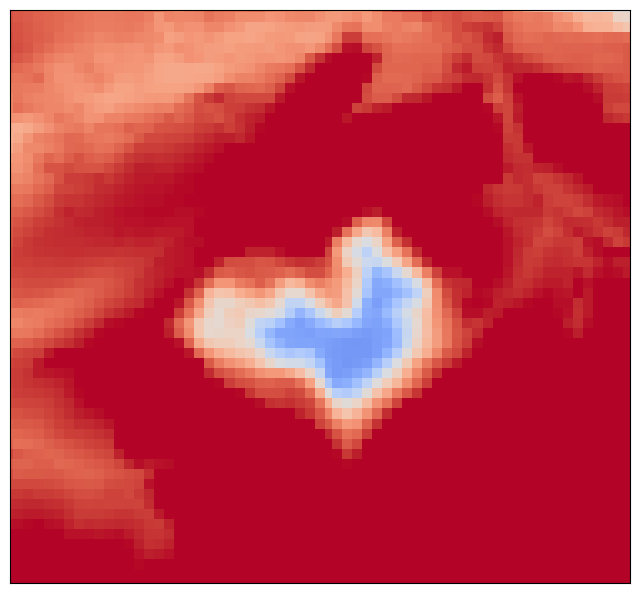

In [123]:
with rasterio.open(dem_img_path) as src:
    dem_img = src.read(1)

min_elevation = dem_img.min()
max_elevation = dem_img.max()

print(f"Minimum elevation in image is: {min_elevation:.2f} m")
print(f"Maximum elevation in image is: {max_elevation:.2f} m")
plot_image(dem_img, factor=1.5, cmap=plt.cm.coolwarm, vmin=min_elevation, vmax=max_elevation, figsize=(8,8))

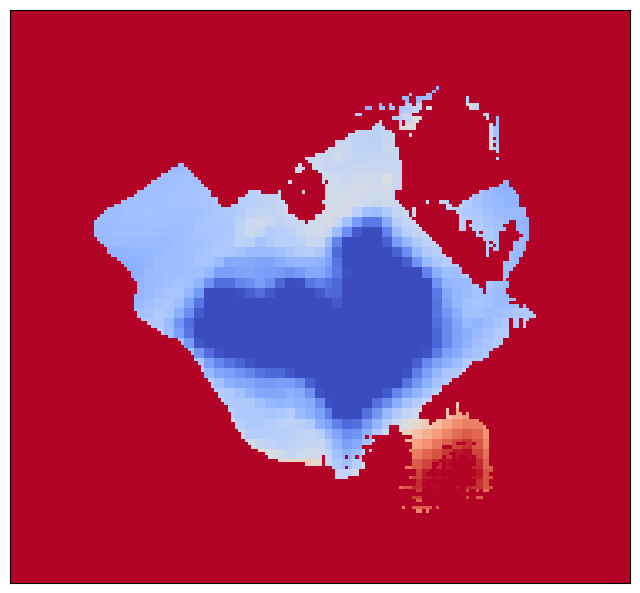

In [124]:
dem_img[masks[0] != 1] = 0
dem_img[masks[0] == 1] -= dem_img.max()

min_elevation = dem_img.min()
max_elevation = dem_img.max()

plot_image(dem_img, factor=1.5, cmap=plt.cm.coolwarm, vmin=min_elevation, vmax=max_elevation, figsize=(8,8))

In [125]:
# Note: This volume calculation is very rough, and meant as an order of magnitude calculation only
volume = get_volume_from_dem_array(dem_img, resolution=10)

print(f"Calculated volume of the pit is: {volume:.3f} cubic kilometers")

Calculated volume of the pit is: 0.081 cubic kilometers
